**Problem Description:**

The challenge is a binary image classification task aimed at detecting metastatic cancer in small image patches extracted from larger digital pathology scans. Specifically, the goal is to develop an algorithm that can accurately classify these patches as either containing metastatic cancer (positive label) or not (negative label). The presence of cancer is determined solely by the presence of tumor tissue within the center 32x32 pixel region of each patch. This task has significant clinical relevance, as it directly addresses the critical issue of cancer metastasis detection.

**Data Description:**

The dataset is a modified version of the PatchCamelyon (PCam) benchmark dataset. It consists of a large number of small, color pathology images.

-   **Size:** The dataset comprises thousands of image patches, split into training and testing sets.
-   **Dimension:** Each image patch has a fixed dimension of 96x96 pixels with 3 color channels (RGB).
-   **Structure:**
    -   The data is organized into two main folders: `train` and `test`.
    -   The `train` folder contains images for training the model, and the `test` folder contains images for which predictions are to be made.
    -   A `train_labels.csv` file provides the ground truth labels for the training images, mapping image IDs to binary labels (0 or 1).
    -   The labels are only determined by the center 32x32 pixel region of each image.
    -   The outer area of the 96x96 images are provided to support fully convolutional network architectures.
-   **Format:** Images are in standard image formats (tif).
-   **Class Imbalance:** It's important to note that the dataset may exhibit class imbalance, with a potentially unequal distribution of positive and negative samples.
-   **No Duplicates:** The Kaggle version of the PCam dataset has been processed to remove duplicate images, ensuring a cleaner training set.

In [8]:
import albumentations as A
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

In [9]:
# load data
train_labels = pd.read_csv('data/train_labels.csv')
train_dir = 'data/train/'
test_dir = 'data/test/'

# Display the first few rows of the labels
print(train_labels.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


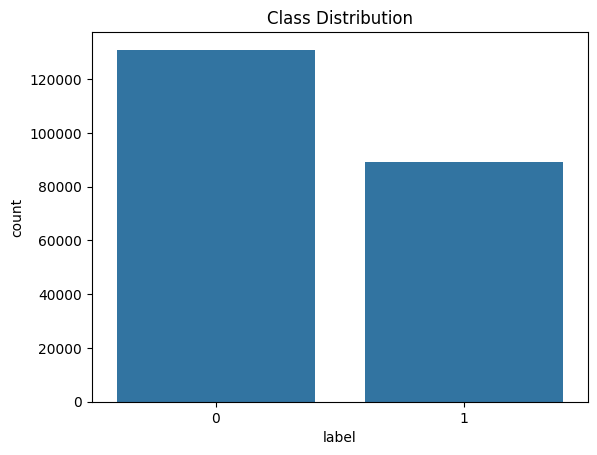

label
0    130908
1     89117
Name: count, dtype: int64


In [10]:
#  Visualizing Class Distribution

sns.countplot(x='label', data=train_labels)
plt.title('Class Distribution')
plt.show()

print(train_labels['label'].value_counts())

#### **Verify Center Region Importance**

In [11]:
# Get positive & negative samples
positive_samples = train_labels[train_labels['label'] == 1].sample(n=5, random_state=42)
negative_samples = train_labels[train_labels['label'] == 0].sample(n=5, random_state=42)

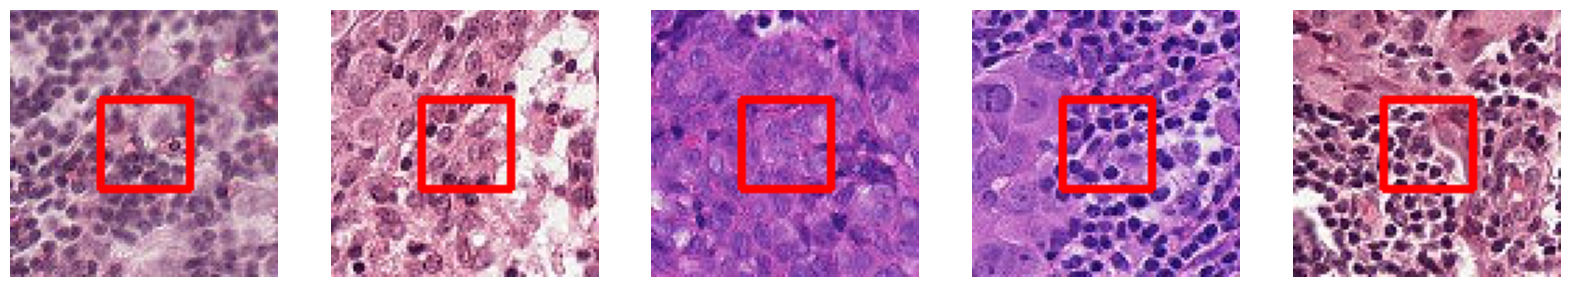

In [12]:
# Plot images with center region highlighted, positive samples
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for ax, (idx, row) in zip(axes, positive_samples.iterrows()):
    img = cv2.imread(f'data/train/{row.id}.tif')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.rectangle(img, (32, 32), (64, 64), (255, 0, 0), 2)  # Center 32x32
    ax.imshow(img)
    ax.axis('off')
plt.show()

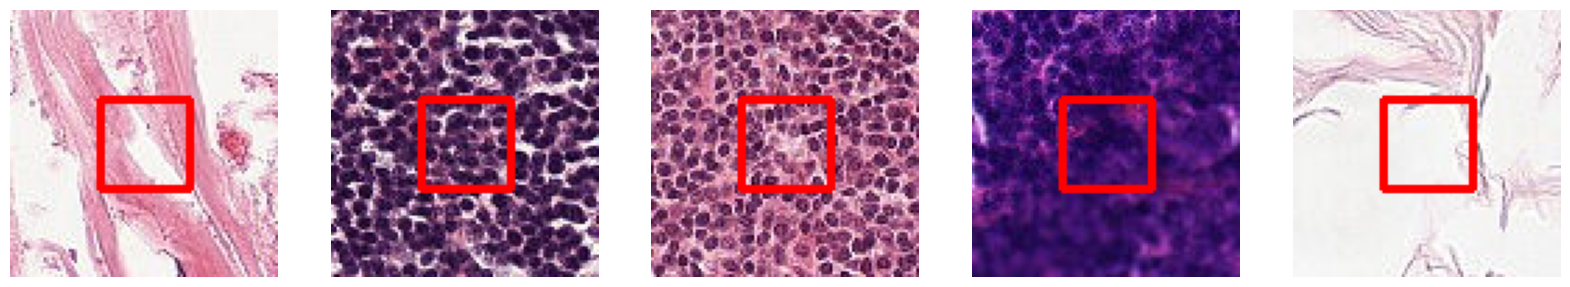

In [13]:
# Plot images with center region highlighted, negative samples
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for ax, (idx, row) in zip(axes, negative_samples.iterrows()):
    img = cv2.imread(f'data/train/{row.id}.tif')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.rectangle(img, (32, 32), (64, 64), (255, 0, 0), 2)  # Center 32x32
    ax.imshow(img)
    ax.axis('off')

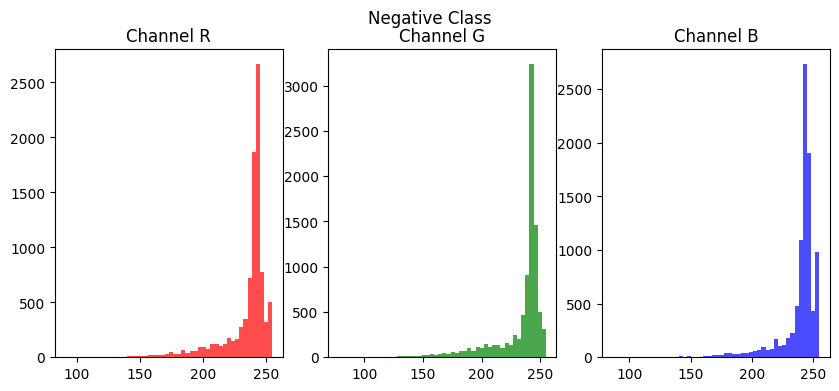

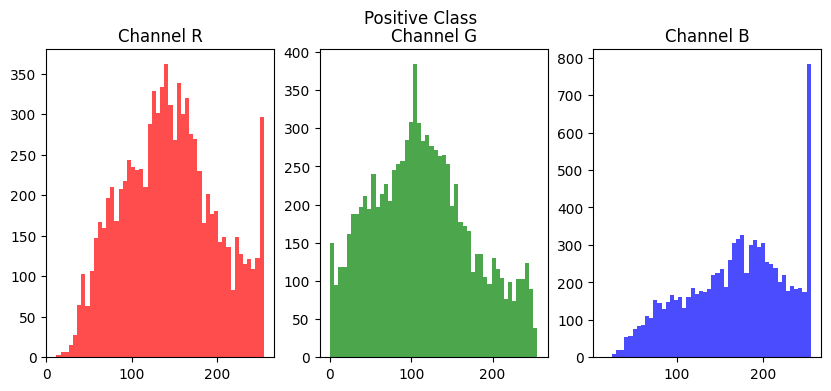

In [14]:
# Compare color histograms for positive/negative classes

def plot_color_histogram(images, title):
    plt.figure(figsize=(10, 4))
    for i in range(3):  # RGB channels
        plt.subplot(1, 3, i+1)
        plt.hist(images[..., i].ravel(), bins=50, color=['r', 'g', 'b'][i], alpha=0.7)
        plt.title(f'Channel {["R", "G", "B"][i]}')
    plt.suptitle(title)
    plt.show()

# Sample images from each class
for(idx, row) in positive_samples.iterrows():
    pos_img = cv2.imread(f'data/train/{row.id}.tif')

for (idx, row) in negative_samples.iterrows():
    neg_img = cv2.imread(f'data/train/{row.id}.tif')


plot_color_histogram(neg_img, 'Negative Class')
plot_color_histogram(pos_img, 'Positive Class')

In [15]:
# Calculate class weights for loss function

class_counts = train_labels['label'].value_counts()
total = class_counts.sum()
weight_for_0 = total / (2 * class_counts[0])  # Negative class
weight_for_1 = total / (2 * class_counts[1])  # Positive class
class_weights = {0: weight_for_0, 1: weight_for_1}
print(f"Class Weights: {class_weights}")

Class Weights: {0: 0.840380267057781, 1: 1.234472659537462}


In [16]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5, border_mode=cv2.BORDER_CONSTANT),
    A.CLAHE(p=0.2),
])

/Users/rohangupta/Library/Python/3.9/lib/python/site-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
